In [1]:
from ESDIRK23 import ESDIRK23_solver
from DP54 import DP54_solver
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time
import numba
from matplotlib.gridspec import GridSpec

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')  
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.fontsize'] = 13

In [3]:
t_range = np.array((0.0, 50.0))
h_size = np.array((1e-12 ,1e0))
x0 = np.array((0.5, 1.0, 250.0))
argv = np.array([
    np.exp(24.6),  # k0
    8500.0,        # Ea_R
    - 560.0,        # deltaHr
    1.0,           # rho
    4.186,         # cP
    1e-0 ,           # F 
    1.0,           # V 
    1.0,           # CA_in
    2.0,           # CB_in
    300.0          # T_in
])
reps = 1e-8
aeps = 1e-10
num_var = np.size(x0)
model = 3 # 1 is van der pol model
MAX_STEPS = int(2000)
t_history, x_history, t_adaptive_size, t_adaptive = ESDIRK23_solver(x0, argv, t_range, h_size, reps, aeps, model, MAX_STEPS)

Time: 0.001487 seconds
step size number is: 1610


In [4]:
def cstr_3state(t, y, argv):
    # Extract state variables
    CA, CB, T = y
    
    # Extract parameters from argv array
    k0 = argv[0]      # Arrhenius constant
    Ea_R = argv[1]    # Activation energy / gas constant
    deltaHr = argv[2] # Reaction enthalpy
    rho = argv[3]     # Density
    cP = argv[4]      # Specific heat capacity
    F = argv[5]       # Flow rate
    V = argv[6]       # Reactor volume
    CA_in = argv[7]   # Inlet concentration of A
    CB_in = argv[8]   # Inlet concentration of B
    T_in = argv[9]    # Inlet temperature
    
    # Compute reaction rate
    k = k0 * np.exp(-Ea_R / T)  # Rate constant
    r = k * CA * CB             # Reaction rate
    
    # Temperature effect parameter
    beta = -deltaHr / (rho * cP)
    
    # Compute derivatives
    dCA_dt = (CA_in - CA) * (F / V) - r
    dCB_dt = (CB_in - CB) * (F / V) - 2.0 * r
    dT_dt = (T_in - T) * (F / V) + beta * r
    
    return [dCA_dt, dCB_dt, dT_dt]


In [5]:
def jac_cstr_3state(t, y, argv):
    # Extract state variables
    CA, CB, T = y
    
    # Extract parameters from argv array
    k0 = argv[0]      # Arrhenius constant
    Ea_R = argv[1]    # Activation energy / gas constant
    deltaHr = argv[2] # Reaction enthalpy
    rho = argv[3]     # Density
    cP = argv[4]      # Specific heat capacity
    F = argv[5]       # Flow rate
    V = argv[6]       # Reactor volume
    CA_in = argv[7]   # Inlet concentration of A
    CB_in = argv[8]   # Inlet concentration of B
    T_in = argv[9]    # Inlet temperature
    
    # Compute reaction rate constants
    k = k0 * np.exp(-Ea_R / T)  # Rate constant
    
    # Temperature effect parameter
    beta = -deltaHr / (rho * cP)
    
    # Compute the Jacobian matrix
    jac = np.zeros((3, 3))
    
    # ∂(dCA_dt)/∂CA
    jac[0, 0] = -(F / V) - k * CB
    
    # ∂(dCA_dt)/∂CB
    jac[0, 1] = -k * CA
    
    # ∂(dCA_dt)/∂T
    jac[0, 2] = -k * (Ea_R / (T**2)) * CA * CB
    
    # ∂(dCB_dt)/∂CA
    jac[1, 0] = -2.0 * k * CB
    
    # ∂(dCB_dt)/∂CB
    jac[1, 1] = -(F / V) - 2.0 * k * CA
    
    # ∂(dCB_dt)/∂T
    jac[1, 2] = -2.0 * k * (Ea_R / (T**2)) * CA * CB
    
    # ∂(dT_dt)/∂CA
    jac[2, 0] = beta * k * CB
    
    # ∂(dT_dt)/∂CB
    jac[2, 1] = beta * k * CA
    
    # ∂(dT_dt)/∂T
    jac[2, 2] = -(F / V) + beta * k * (Ea_R / (T**2)) * CA * CB
    
    return jac


In [6]:
h_size = np.array((1e-12 ,1e3))
start = time.perf_counter()
result = solve_ivp(
    lambda t, y: cstr_3state(t, y, argv),
    t_span = t_range,
    y0 = x0,
    method='Radau',
    jac = lambda t, y: jac_cstr_3state(t, y, argv),
    rtol=reps,          
    atol=aeps, 
    #t_eval=np.linspace(0, 100, 1000),
    first_step=h_size[0],  
    max_step=h_size[1],   
)
t_history_scipy = result.t           
x_history_1_scipy = result.y[0, :]   
x_history_2_scipy = result.y[1, :]  
x_history_3_scipy = result.y[2, :]  
step_sizes = np.diff(result.t)
end = time.perf_counter()
elapsed = end - start

print(f"Time: {elapsed} seconds")

Time: 0.0538017088547349 seconds


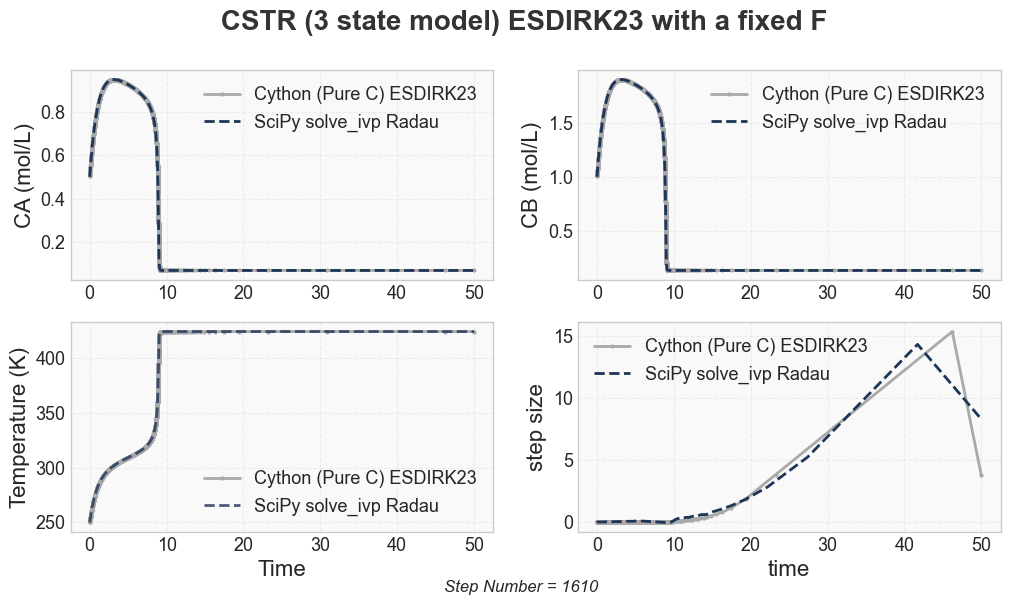

In [7]:
x_history_1 = x_history[:, 0]
x_history_2 = x_history[:, 1]
x_history_3 = x_history[:, 2]
fig = plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-whitegrid') 
gs = GridSpec(2, 2, figure=fig)
pic1 = fig.add_subplot(gs[0, 0])
pic2 = fig.add_subplot(gs[0, 1])
pic4 = fig.add_subplot(gs[1, 0])
pic3 = fig.add_subplot(gs[1, 1])
pic1.plot(t_history, x_history_1, '#A9A9A9', linewidth=2, markersize=4, marker='.', alpha=1, label=f'Cython (Pure C) ESDIRK23')    
pic2.plot(t_history, x_history_2, '#A9A9A9', linewidth=2, markersize=4, marker='.', alpha=1, label=f'Cython (Pure C) ESDIRK23') 
pic1.plot(t_history_scipy, x_history_1_scipy, '#1D3557', linewidth=2, markersize=4, alpha=1, linestyle='--', label=f'SciPy solve_ivp Radau')    
pic2.plot(t_history_scipy, x_history_2_scipy, '#1D3557', linewidth=2, markersize=4, alpha=1, linestyle='--', label=f'SciPy solve_ivp Radau') 
pic4.plot(t_history, x_history_3, '#A9A9A9', linewidth=2, marker='.', markersize=4, label=f'Cython (Pure C) ESDIRK23', alpha=1)    
pic3.plot(t_adaptive, t_adaptive_size, '#A9A9A9', linewidth=2, marker='.', markersize=4, alpha=1, label=f'Cython (Pure C) ESDIRK23')  
pic3.plot(t_history_scipy[1:], step_sizes, '#1D3557', linewidth=2, markersize=4, alpha=1, linestyle='--', label=f'SciPy solve_ivp Radau')  
pic4.plot(t_history_scipy, x_history_3_scipy, '#1D3557', linewidth=2, markersize=4, label=f'SciPy solve_ivp Radau', alpha=0.8, linestyle='--')   
#pic4.set_yscale('log')  
pic1.set_ylabel('CA (mol/L)')
pic2.set_ylabel('CB (mol/L)')
pic3.set_xlabel('time')
pic3.set_ylabel('step size')
pic2.grid(True, which="both", ls="--", alpha=0.3)
pic3.grid(True, which="both", ls="--", alpha=0.3)
pic1.grid(True, which="both", ls="--", alpha=0.3)
pic4.set_xlabel('Time')
pic4.set_ylabel('Temperature (K)')
pic4.grid(True, which="both", ls="--", alpha=0.3)
pic1.legend() 
pic2.legend() 
pic3.legend() 
pic4.legend() 
pic1.set_facecolor('#f9f9f9')
pic2.set_facecolor('#f9f9f9')
pic3.set_facecolor('#f9f9f9')
pic4.set_facecolor('#f9f9f9')

#fig.suptitle('Prey-Predator Model ', fontsize=18, fontweight='bold')
fig.suptitle(' CSTR (3 state model) ESDIRK23 with a fixed F', fontsize=20, fontweight='bold', color='#333333', y=0.98)
fig.text(0.5, 0.01, f'Step Number = {t_history.shape[0]}', ha='center', fontsize=12, style='italic')
plt.savefig("ESDIRK23_CSTR3.png")


In [8]:
t_range = np.array((0.0, 50.0))
h_size = np.array((1e-12 ,1e-4))
x0 = np.array((0.5, 1.0, 350.0))
argv = np.array([
    np.exp(24.6),  # k0
    8500.0,        # Ea_R
    - 560.0,        # deltaHr
    1.0,           # rho
    4.186,         # cP
    1e0 * 8 ,           # F 
    1.0,           # V 
    1.0,           # CA_in
    2.0,           # CB_in
    300.0          # T_in
])
reps = 1e-10
aeps = 1e-12
num_var = np.size(x0)
model = 3 # 1 is van der pol model
MAX_STEPS = int(10000)
#t_history, x_history, t_adaptive_size, t_adaptive = DP54_solver(x0, argv, t_range, h_size, reps, aeps, model, MAX_STEPS)


In [9]:
T1 = []
CA1 = []
CB1 = []
T1.append(argv[9])
Fs1 = []
time1 = []
time1.append(0)
for i in range (4000):
    t_history, x_history, t_adaptive_size, t_adaptive = ESDIRK23_solver(x0, argv, t_range, h_size, reps, aeps, model, MAX_STEPS)
    T1.append(x_history[-1, 2])
    if abs(T1[-1] - T1[-2]) > 0.01 * T1[0]:
        del T1[-1]
        del T1[0]
        break
    Fs1.append(argv[5])
    CA1.append(x_history[-1, 0])
    CB1.append(x_history[-1, 1])
    time1.append(time1[-1] + 50)
    argv[5] -= 0.01
    x0[0] = x_history[-1, 0]
    x0[1] = x_history[-1, 1]
    x0[2] = x_history[-1, 2]
T2 = []
CA2 = []
CB2 = []
T2.append(T1[-1])
Fs2 = []
time2 = []
time2.append(time1[-1])
for i in range (500):
    t_history, x_history, t_adaptive_size, t_adaptive = ESDIRK23_solver(x0, argv, t_range, h_size, reps, aeps, model, MAX_STEPS)
    T2.append(x_history[-1, 2])
    if abs(T2[-1] - T2[-2]) > 0.01 * T2[0] and i != 0:
        del T2[-1]
        del T2[0]
        break
    CA2.append(x_history[-1, 0])
    CB2.append(x_history[-1, 1])
    time2.append(time2[-1] + 50)
    argv[5] += 0.01
    Fs2.append(argv[5])
    x0[0] = x_history[-1, 0]
    x0[1] = x_history[-1, 1]
    x0[2] = x_history[-1, 2]

T3 = []
CA3 = []
CB3 = []
time3 = []
time3.append(time2[-1])
T3.append(T2[-2])
x0[0] = CA2[-2]
x0[1] = CB2[-2]
x0[2] = T2[-2]
Fs3 = []
Fs3.append(Fs2[-2])
argv[5] = Fs2[-2]
for i in range (500):
    t_history, x_history, t_adaptive_size, t_adaptive = ESDIRK23_solver(x0, argv, t_range, h_size, reps, aeps, model, MAX_STEPS)
    T3.append(x_history[-1, 2])
    if Fs3[0] <= 0:
        del T3[-1]
        del T3[0]
        break
    CA3.append(x_history[-1, 0])
    CB3.append(x_history[-1, 1])
    time3.append(time3[-1] + 50)
    argv[5] -= 0.01
    Fs3.append(argv[5])
    x0[0] = x_history[-1, 0]
    x0[1] = x_history[-1, 1]
    x0[2] = x_history[-1, 2]


Time: 0.001532 seconds
step size number is: 1965
Time: 0.000379 seconds
step size number is: 60
Time: 0.000154 seconds
step size number is: 60
Time: 0.000114 seconds
step size number is: 60
Time: 0.000145 seconds
step size number is: 60
Time: 0.000092 seconds
step size number is: 60
Time: 0.000118 seconds
step size number is: 60
Time: 0.000058 seconds
step size number is: 60
Time: 0.000056 seconds
step size number is: 60
Time: 0.000058 seconds
step size number is: 60
Time: 0.000052 seconds
step size number is: 60
Time: 0.000050 seconds
step size number is: 60
Time: 0.000039 seconds
step size number is: 60
Time: 0.000039 seconds
step size number is: 60
Time: 0.000054 seconds
step size number is: 60
Time: 0.000042 seconds
step size number is: 60
Time: 0.000041 seconds
step size number is: 61
Time: 0.000045 seconds
step size number is: 61
Time: 0.000039 seconds
step size number is: 61
Time: 0.000031 seconds
step size number is: 61
Time: 0.000035 seconds
step size number is: 61
Time: 0.000

In [10]:
def bezier_curve(p0, p1, num=20):
    control_x = (p0[0] + p1[0])/2
    control_y = (p0[1] + p1[1])/2 + abs(p1[1] - p0[1])*0.2
    control = (control_x, control_y)
    t = np.linspace(0, 1, num)
    x = (1-t)**2 * p0[0] + 2*(1-t)*t * control[0] + t**2 * p1[0]
    y = (1-t)**2 * p0[1] + 2*(1-t)*t * control[1] + t**2 * p1[1]
    return x, y

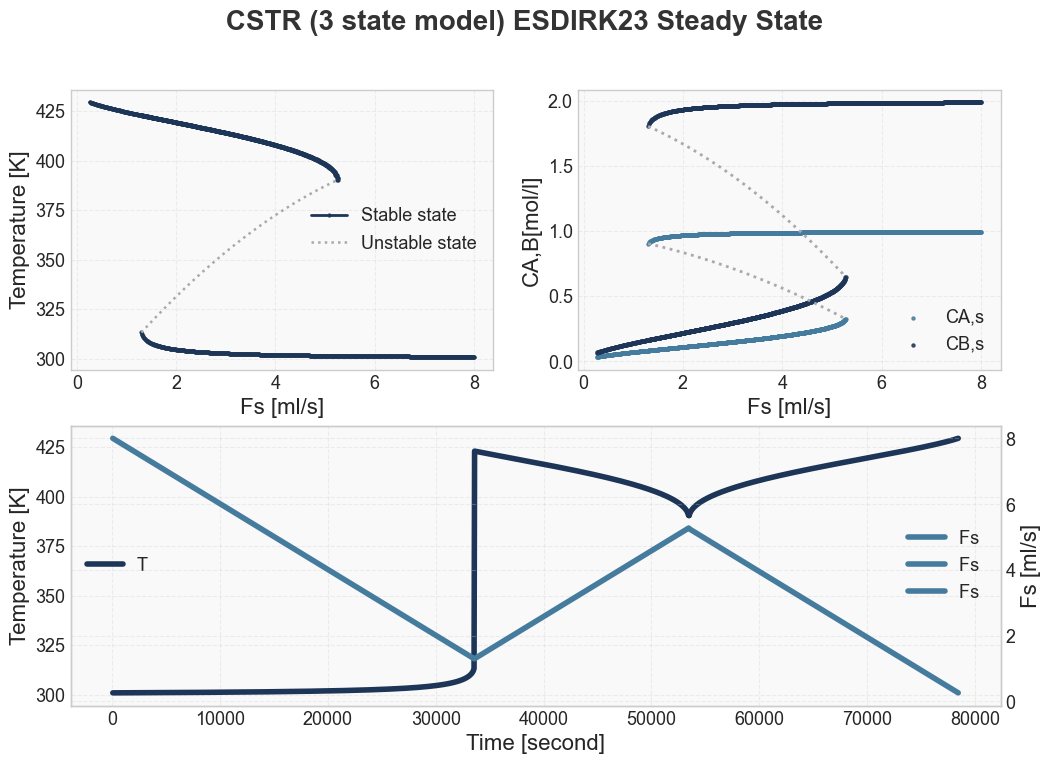

In [11]:
fig = plt.figure(figsize=(12, 8))
plt.style.use('seaborn-v0_8-whitegrid') 
gs = GridSpec(2, 2, figure=fig)
pic5 = fig.add_subplot(gs[0, 0])
pic6 = fig.add_subplot(gs[0, 1])
pic7 = fig.add_subplot(gs[1, :])
pic8 = pic7.twinx()
pic5.plot(Fs1, T1, '#1D3557', linewidth=2, markersize=4, marker='.', alpha=1, label=f'Stable state')    
pic5.plot(Fs2, T2, '#1D3557', linewidth=2, markersize=4, marker='.', alpha=1, label=f'')   
pic5.plot(Fs3, T3, '#1D3557', linewidth=2, markersize=4, marker='.', alpha=1, label=f'')   
end_point1 = (Fs1[-1], T1[-1])
end_point2 = (Fs2[-1], T2[-1])
x_bezier, y_bezier = bezier_curve(end_point1, end_point2, num=30)
pic5.plot(x_bezier, y_bezier, color='#A9A9A9', linewidth=1.8, linestyle=':', alpha=1, label='Unstable state')
time = time1[1:] + time2[1:] + time3[:]
T = T1 + T2 + T3
pic7.plot(time, T, '#1D3557', linewidth=4, alpha=1, label=f'T ')    
pic8.plot(time1[1:], Fs1, '#457B9D', linewidth=4, alpha=1, label=f'Fs ')    
pic8.plot(time2[1:], Fs2, '#457B9D', linewidth=4, alpha=1, label=f'Fs ')   
pic8.plot(time3[:], Fs3, '#457B9D', linewidth=4, alpha=1, label=f'Fs ') 
end_point1 = (Fs1[-1], CA1[-1])
end_point2 = (Fs2[-1], CA2[-1])
x_bezier, y_bezier = bezier_curve(end_point1, end_point2, num=30)   
pic6.scatter(Fs1, CA1, c='#457B9D', s=20, alpha=0.8, marker='.', label='CA,s')
pic6.scatter(Fs2, CA2, c='#457B9D', s=20, alpha=0.8, marker='.')
pic6.scatter(Fs3[:-1], CA3, c='#457B9D', s=20, alpha=0.8, marker='.')
pic6.plot(x_bezier, y_bezier, color='#A9A9A9', linewidth=2, linestyle=':', alpha=1)
end_point1 = (Fs1[-1], CB1[-1])
end_point2 = (Fs2[-1], CB2[-1])
x_bezier, y_bezier = bezier_curve(end_point1, end_point2, num=30)   
pic6.scatter(Fs1, CB1, c='#1D3557', s=20, alpha=0.8, marker='.', label='CB,s')
pic6.scatter(Fs2, CB2, c='#1D3557', s=20, alpha=0.8, marker='.')
pic6.scatter(Fs3[:-1], CB3, c='#1D3557', s=20, alpha=0.8, marker='.')
pic6.plot(x_bezier, y_bezier, color='#A9A9A9', linewidth=2, linestyle=':', alpha=1)
pic5.set_facecolor('#f9f9f9')
pic6.set_facecolor('#f9f9f9')
pic7.set_facecolor('#f9f9f9')
pic8.set_facecolor('#f9f9f9')
pic5.grid(True, which="both", ls="--", alpha=0.3)
pic6.grid(True, which="both", ls="--", alpha=0.3)
pic7.grid(True, which="both", ls="--", alpha=0.3)
pic8.grid(True, which="both", ls="--", alpha=0.3)
pic5.set_xlabel('Fs [ml/s]')
pic5.set_ylabel('Temperature [K]')
pic6.set_xlabel('Fs [ml/s]')
pic6.set_ylabel('CA,B[mol/l]')
pic7.set_xlabel('Time [second]')
pic7.set_ylabel('Temperature [K]')
pic8.set_ylabel('Fs [ml/s]')
pic5.legend() 
pic6.legend() 
pic7.legend(fontsize=13, loc = 'center left',frameon=False, fancybox=True) 
pic8.legend(fontsize=13, loc = 'center right',frameon=False, fancybox=True) 
fig.suptitle(' CSTR (3 state model) ESDIRK23 Steady State', fontsize=20, fontweight='bold', color='#333333', y=0.98)
plt.savefig("ESDIRK23_CSTR3_Steady_state.png")